# Correction Complète - TP Tests Statistiques
## Optimisation d'une Plateforme E-commerce

Ce notebook contient la correction détaillée des 4 parties du TP, avec des explications pédagogiques et l'utilisation des fonctions intégrées de Python (scipy, statsmodels, pingouin).

In [1]:
# Installation des dépendances si nécessaire
!pip install pandas numpy scipy statsmodels pingouin scikit-posthocs matplotlib seaborn

   ---------------------------------------- 0.0/204.4 kB ? eta -:--:--
   ---------------------------------------- 204.4/204.4 kB 6.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ----------------------- ---------------- 0.8/1.4 MB 17.0 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 17.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, levene, ttest_ind, f_oneway, kruskal, wilcoxon, norm, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
import scikit_posthocs as sp
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
print("Librairies chargées avec succès.")

Librairies chargées avec succès.


---
# PARTIE 1 : Test A/B - Optimisation de la Page Produit

**Contexte** : L'équipe UX a créé une nouvelle version de la page produit. On compare le taux de conversion entre la version A (contrôle) et la version B (nouveau design).

In [2]:
df_ab = pd.read_csv('ab_test_data.csv')
print(f"Données : {df_ab.shape[0]} lignes, {df_ab.shape[1]} colonnes")
df_ab.head()

Données : 5000 lignes, 4 colonnes


,user_id,variant,converted,purchase_amount
0,0,A,0,0.000000
1,1,A,1,50.433272
2,2,A,0,0.000000
3,3,A,0,0.000000
4,4,A,0,0.000000


### Q1.1 : Taux de conversion par variante

In [3]:
# Calcul des métriques par variante
stats_ab = df_ab.groupby('variant')['converted'].agg(['sum', 'count', 'mean'])
stats_ab.columns = ['conversions', 'visiteurs', 'taux_conversion']
print(stats_ab)

# Extraire les valeurs
n_A, n_B = int(stats_ab.loc['A', 'visiteurs']), int(stats_ab.loc['B', 'visiteurs'])
conv_A, conv_B = int(stats_ab.loc['A', 'conversions']), int(stats_ab.loc['B', 'conversions'])
rate_A, rate_B = stats_ab.loc['A', 'taux_conversion'], stats_ab.loc['B', 'taux_conversion']

# Différences
diff_abs = rate_B - rate_A
lift = (rate_B - rate_A) / rate_A * 100

print(f"\nTaux A : {rate_A:.4f} ({rate_A*100:.2f}%)")
print(f"Taux B : {rate_B:.4f} ({rate_B*100:.2f}%)")
print(f"Différence absolue : {diff_abs:.4f} ({diff_abs*100:.2f} points de %)")
print(f"Lift (différence relative) : +{lift:.2f}%")

         conversions  visiteurs  taux_conversion
variant                                         
A                294       2500           0.1176
B                337       2500           0.1348

Taux A : 0.1176 (11.76%)
Taux B : 0.1348 (13.48%)
Différence absolue : 0.0172 (1.72 points de %)
Lift (différence relative) : +14.63%


**Interprétation** :
- La variante B affiche un taux de conversion supérieur (+1.72 points de %).
- En termes relatifs, c'est un lift de +14.63%. Reste à vérifier si cette différence est statistiquement significative.

### Q1.2 : Visualisation avec intervalles de confiance

IC 95% Variante A : [0.1056, 0.1308]
IC 95% Variante B : [0.1220, 0.1487]


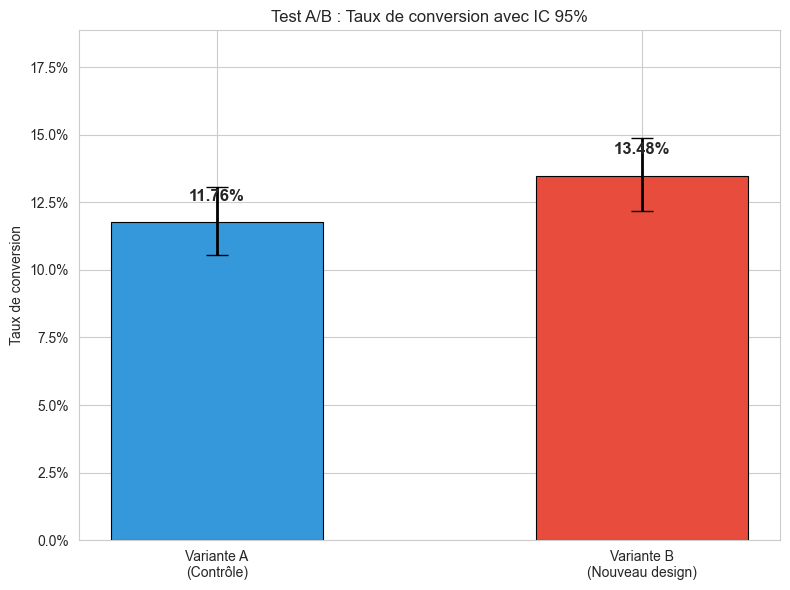

In [4]:
# Intervalles de confiance à 95% (méthode de Wilson, plus fiable pour les proportions)
ci_A = proportion_confint(conv_A, n_A, alpha=0.05, method='wilson')
ci_B = proportion_confint(conv_B, n_B, alpha=0.05, method='wilson')

print(f"IC 95% Variante A : [{ci_A[0]:.4f}, {ci_A[1]:.4f}]")
print(f"IC 95% Variante B : [{ci_B[0]:.4f}, {ci_B[1]:.4f}]")

# Graphique
fig, ax = plt.subplots(figsize=(8, 6))
variants = ['Variante A\n(Contrôle)', 'Variante B\n(Nouveau design)']
rates = [rate_A, rate_B]
errors = [[rate_A - ci_A[0], rate_B - ci_B[0]], [ci_A[1] - rate_A, ci_B[1] - rate_B]]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(variants, rates, color=colors, width=0.5, edgecolor='black', linewidth=0.8)
ax.errorbar(variants, rates, yerr=errors, fmt='none', ecolor='black', capsize=8, linewidth=2)

for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008,
            f'{rate*100:.2f}%', ha='center', fontsize=12, fontweight='bold')

ax.set_ylabel('Taux de conversion')
ax.set_title('Test A/B : Taux de conversion avec IC 95%')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
ax.set_ylim(0, max(rates) * 1.4)
plt.tight_layout()
plt.show()

**Observation** : Les intervalles de confiance se chevauchent. C'est un premier indice visuel que la différence pourrait ne pas être significative.

### Q1.3 : Vérification des conditions d'application

Pour un **test de proportion (test Z)**, on ne vérifie pas la normalité des données brutes (elles sont binaires : 0/1).

Les conditions sont :
1. **Indépendance** : Assignation aléatoire 50/50, chaque visiteur dans un seul groupe.
2. **Taille suffisante** : `n*p >= 5` et `n*(1-p) >= 5` pour chaque groupe.

In [5]:
# Vérification de la condition de taille
print("Condition : n*p >= 5 ET n*(1-p) >= 5 pour chaque groupe")
print(f"\nVariante A : n*p = {n_A * rate_A:.0f} >= 5, n*(1-p) = {n_A * (1-rate_A):.0f} >= 5")
print(f"Variante B : n*p = {n_B * rate_B:.0f} >= 5, n*(1-p) = {n_B * (1-rate_B):.0f} >= 5")
print("\n-> Conditions largement respectées. Le test Z est valide.")

Condition : n*p >= 5 ET n*(1-p) >= 5 pour chaque groupe

Variante A : n*p = 294 >= 5, n*(1-p) = 2206 >= 5
Variante B : n*p = 337 >= 5, n*(1-p) = 2163 >= 5

-> Conditions largement respectées. Le test Z est valide.


### Q1.4 : Test de proportion (test Z)

**Hypothèses** :
- H0 : pA = pB (les taux de conversion sont identiques)
- H1 : pA != pB (les taux diffèrent - test bilatéral)

In [6]:
# Test Z de proportion avec proportions_ztest (une seule fonction)
z_stat, p_value_z = proportions_ztest(
    count=np.array([conv_B, conv_A]),
    nobs=np.array([n_B, n_A]),
    alternative='two-sided'
)

print(f"Z-statistique : {z_stat:.4f}")
print(f"P-value : {p_value_z:.4f}")

Z-statistique : 1.8313
P-value : 0.0671


### Q1.5 : Interprétation de la p-value

In [7]:
alpha = 0.05

if p_value_z < alpha:
    print(f"p-value ({p_value_z:.4f}) < alpha ({alpha})")
    print("-> ON REJETTE H0 : Différence SIGNIFICATIVE")
else:
    print(f"p-value ({p_value_z:.4f}) >= alpha ({alpha})")
    print("-> ON NE REJETTE PAS H0 : Différence NON significative")
    print(f"\nIl y a {p_value_z*100:.2f}% de chances d'observer une telle différence")
    print("si en réalité les deux variantes ont le même taux de conversion.")

p-value (0.0671) >= alpha (0.05)
-> ON NE REJETTE PAS H0 : Différence NON significative

Il y a 6.71% de chances d'observer une telle différence
si en réalité les deux variantes ont le même taux de conversion.


### Q1.6 : Lift et intervalle de confiance de la différence

Lift : +14.63%

IC 95% de la différence (pB - pA) : [-0.12%, 3.56%]
L'IC contient 0 -> Non significatif


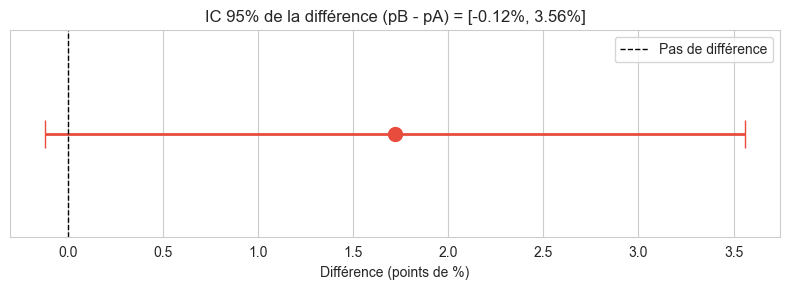

In [8]:
# Lift
print(f"Lift : +{lift:.2f}%")

# IC à 95% de la différence (pB - pA)
diff = rate_B - rate_A
se_diff = np.sqrt(rate_A*(1-rate_A)/n_A + rate_B*(1-rate_B)/n_B)
z_crit = norm.ppf(0.975)  # 1.96

ci_lower = diff - z_crit * se_diff
ci_upper = diff + z_crit * se_diff

print(f"\nIC 95% de la différence (pB - pA) : [{ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")
print(f"L'IC {'ne contient PAS' if ci_lower > 0 else 'contient'} 0 -> {'Significatif' if ci_lower > 0 else 'Non significatif'}")

# Visualisation
fig, ax = plt.subplots(figsize=(8, 3))
ax.errorbar(x=diff*100, y=0.5, xerr=z_crit*se_diff*100,
            fmt='o', color='#e74c3c', markersize=10, capsize=10, linewidth=2)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, label='Pas de différence')
ax.set_xlabel('Différence (points de %)')
ax.set_title(f'IC 95% de la différence (pB - pA) = [{ci_lower*100:.2f}%, {ci_upper*100:.2f}%]')
ax.set_yticks([])
ax.legend()
plt.tight_layout()
plt.show()

### Q1.7 : Analyse du montant moyen des achats (test t)

In [9]:
# Filtrer les acheteurs
purchases_A = df_ab[(df_ab['variant'] == 'A') & (df_ab['converted'] == 1)]['purchase_amount']
purchases_B = df_ab[(df_ab['variant'] == 'B') & (df_ab['converted'] == 1)]['purchase_amount']

print(f"Montant moyen A : {purchases_A.mean():.2f} euros (n={len(purchases_A)})")
print(f"Montant moyen B : {purchases_B.mean():.2f} euros (n={len(purchases_B)})")

# Vérification normalité
print(f"\n--- Vérification des conditions ---")
print(f"Shapiro A : p = {shapiro(purchases_A).pvalue:.4f} -> {'Normal' if shapiro(purchases_A).pvalue > 0.05 else 'Non normal (mais n>30, TCL applicable)'}")
print(f"Shapiro B : p = {shapiro(purchases_B).pvalue:.4f} -> {'Normal' if shapiro(purchases_B).pvalue > 0.05 else 'Non normal (mais n>30, TCL applicable)'}")
print(f"Levene : p = {levene(purchases_A, purchases_B).pvalue:.4f} -> {'Variances homogènes' if levene(purchases_A, purchases_B).pvalue > 0.05 else 'Variances non homogènes'}")

# Test t avec pingouin (tout en une seule fonction)
ttest_result = pg.ttest(purchases_B, purchases_A, correction='auto')
print(f"\n--- Test t (pingouin) ---")
print(ttest_result[['T', 'p-val', 'cohen-d', 'CI95%', 'power']].to_string())

print(f"\nConclusion : p = {ttest_result['p-val'].values[0]:.4f} -> Différence {'significative' if ttest_result['p-val'].values[0] < 0.05 else 'NON significative'}")
print(f"Cohen's d = {ttest_result['cohen-d'].values[0]:.4f} -> Effet {'négligeable' if abs(ttest_result['cohen-d'].values[0]) < 0.2 else 'petit' if abs(ttest_result['cohen-d'].values[0]) < 0.5 else 'moyen'}")

Montant moyen A : 99.60 euros (n=294)
Montant moyen B : 103.14 euros (n=337)

--- Vérification des conditions ---
Shapiro A : p = 0.0000 -> Non normal (mais n>30, TCL applicable)
Shapiro B : p = 0.0000 -> Non normal (mais n>30, TCL applicable)
Levene : p = 0.6908 -> Variances homogènes

--- Test t (pingouin) ---
              T    p-val   cohen-d         CI95%     power
T-test  0.64252  0.52077  0.050824  [-7.3, 14.4]  0.097457

Conclusion : p = 0.5208 -> Différence NON significative
Cohen's d = 0.0508 -> Effet négligeable


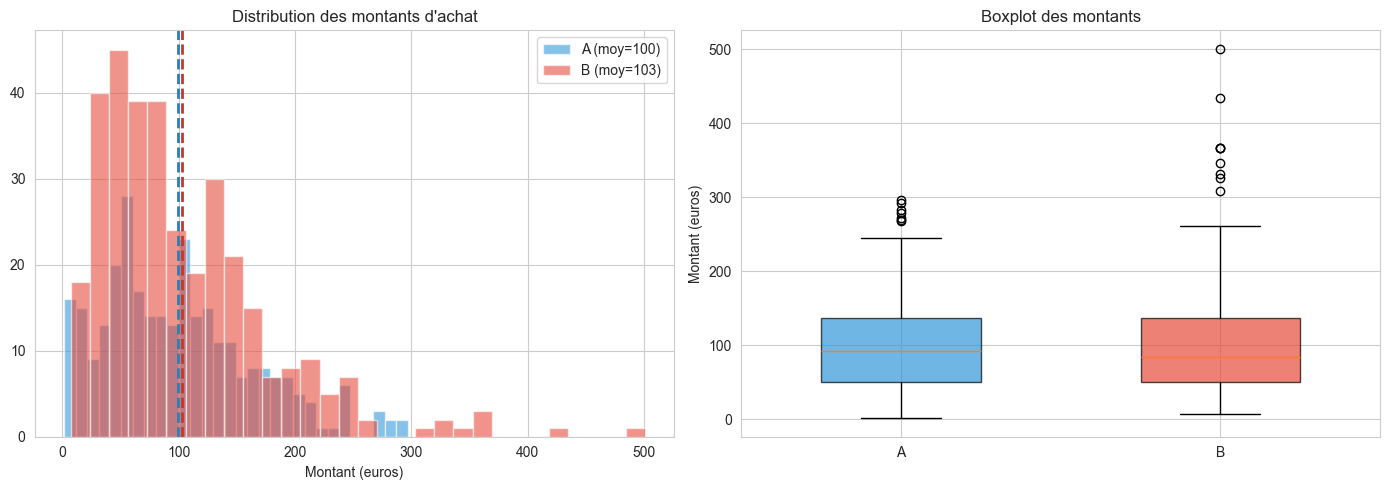

In [10]:
# Visualisation des montants
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(purchases_A, bins=30, alpha=0.6, color='#3498db', label=f'A (moy={purchases_A.mean():.0f})', edgecolor='white')
axes[0].hist(purchases_B, bins=30, alpha=0.6, color='#e74c3c', label=f'B (moy={purchases_B.mean():.0f})', edgecolor='white')
axes[0].axvline(purchases_A.mean(), color='#2980b9', linestyle='--', linewidth=2)
axes[0].axvline(purchases_B.mean(), color='#c0392b', linestyle='--', linewidth=2)
axes[0].set_xlabel('Montant (euros)')
axes[0].set_title('Distribution des montants d\'achat')
axes[0].legend()

bp = axes[1].boxplot([purchases_A, purchases_B], labels=['A', 'B'], patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#e74c3c')
for b in bp['boxes']: b.set_alpha(0.7)
axes[1].set_ylabel('Montant (euros)')
axes[1].set_title('Boxplot des montants')
plt.tight_layout()
plt.show()

### Q1.8 : Puissance statistique

In [12]:
from statsmodels.stats.power import NormalIndPower

# Taille d'effet pour proportions (Cohen's h)
h = 2 * np.arcsin(np.sqrt(rate_B)) - 2 * np.arcsin(np.sqrt(rate_A))
print(f"Taille d'effet (Cohen's h) : {h:.4f}")

# Puissance
power_analysis = NormalIndPower()
power = power_analysis.solve_power(effect_size=h, nobs1=n_A, ratio=1, alpha=0.05, alternative='two-sided')
print(f"Puissance statistique : {power:.4f} ({power*100:.1f}%)")
print(f"-> {'Suffisante (>= 80%)' if power >= 0.80 else 'INSUFFISANTE (< 80%)'}")

# Taille d'échantillon nécessaire pour 80% de puissance
n_required = power_analysis.solve_power(effect_size=h, nobs1=None, ratio=1, alpha=0.05, power=0.80, alternative='two-sided')
print(f"\nTaille d'échantillon requise pour 80% de puissance : {int(np.ceil(n_required))} par groupe")
print(f"Actuellement : {n_A} par groupe")
if n_required > n_A:
    jours_sup = int(np.ceil((n_required - n_A) / (n_A / 14)))
    print(f"-> Il faudrait prolonger le test d'environ {jours_sup} jours")

Taille d'effet (Cohen's h) : 0.0518
Puissance statistique : 0.4493 (44.9%)
-> INSUFFISANTE (< 80%)

Taille d'échantillon requise pour 80% de puissance : 5845 par groupe
Actuellement : 2500 par groupe
-> Il faudrait prolonger le test d'environ 19 jours


### Q1.9 : Recommandation Business

In [13]:
print(f"""
SYNTHÈSE PARTIE 1 - TEST A/B
{'='*50}
Taux conversion A : {rate_A*100:.2f}%
Taux conversion B : {rate_B*100:.2f}%
Lift              : +{lift:.2f}%
IC 95% différence : [{ci_lower*100:.2f}%, {ci_upper*100:.2f}%]

Test Z proportion : p = {p_value_z:.4f} -> {'Significatif' if p_value_z < 0.05 else 'Non significatif'}
Test t montants   : p = {ttest_result['p-val'].values[0]:.4f} -> Non significatif
Puissance         : {power*100:.1f}% -> Insuffisante

RECOMMANDATION : NE PAS DÉPLOYER B immédiatement.
- p = {p_value_z:.4f} est proche du seuil mais non significatif.
- Puissance de {power*100:.1f}% insuffisante (< 80%).
- Prolonger le test (~{jours_sup} jours) pour atteindre {int(np.ceil(n_required))} visiteurs/groupe.
- Signal encourageant : tendance en faveur de B, à confirmer.
""")


SYNTHÈSE PARTIE 1 - TEST A/B
Taux conversion A : 11.76%
Taux conversion B : 13.48%
Lift              : +14.63%
IC 95% différence : [-0.12%, 3.56%]

Test Z proportion : p = 0.0671 -> Non significatif
Test t montants   : p = 0.5208 -> Non significatif
Puissance         : 44.9% -> Insuffisante

RECOMMANDATION : NE PAS DÉPLOYER B immédiatement.
- p = 0.0671 est proche du seuil mais non significatif.
- Puissance de 44.9% insuffisante (< 80%).
- Prolonger le test (~19 jours) pour atteindre 5845 visiteurs/groupe.
- Signal encourageant : tendance en faveur de B, à confirmer.



---
# PARTIE 2 : ANOVA - Test Multi-Promotions

**Contexte** : Le marketing a testé 4 stratégies de promotion (Control, Discount 10%, Livraison gratuite, Combo -15%+livraison). On analyse l'impact sur le montant du panier.

In [14]:
df_promo = pd.read_csv('promotion_test_data.csv')
print(f"Données : {df_promo.shape[0]} lignes")
print(f"Groupes : {df_promo['promotion_type'].unique()}")
df_promo.head()

Données : 1200 lignes
Groupes : <ArrowStringArray>
['Control', 'Discount_10', 'Free_Shipping', 'Combo']
Length: 4, dtype: str


,user_id,promotion_type,basket_amount
0,0,Control,57.859235
1,1,Control,109.933636
2,2,Control,92.074462
3,3,Control,47.342632
4,4,Control,70.534994


### Q2.1 : Statistiques descriptives

In [15]:
order = ['Control', 'Discount_10', 'Free_Shipping', 'Combo']
desc = df_promo.groupby('promotion_type')['basket_amount'].describe().reindex(order)
print(desc.round(2))

                count    mean    std    min    25%     50%     75%     max
promotion_type                                                            
Control         300.0   84.27  25.71   4.22  66.67   84.54  101.66  158.97
Discount_10     300.0   92.02  26.44  16.72  74.93   92.75  110.28  161.12
Free_Shipping   300.0   96.74  26.35  25.34  80.00   95.99  116.60  190.86
Combo           300.0  103.64  29.10   9.99  84.25  104.44  122.46  181.68


### Q2.2 : Visualisation comparative

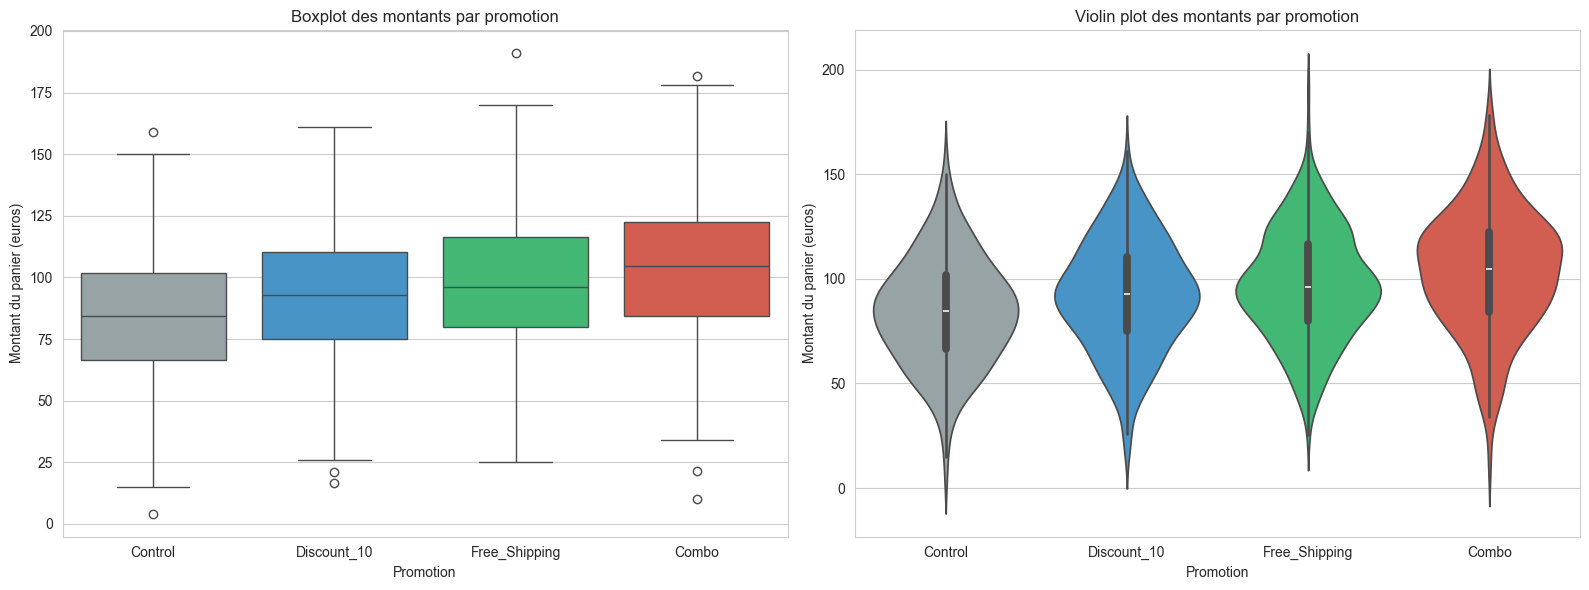

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_promo, x='promotion_type', y='basket_amount',
            order=order, palette=['#95a5a6', '#3498db', '#2ecc71', '#e74c3c'], ax=axes[0])
axes[0].set_title('Boxplot des montants par promotion')
axes[0].set_xlabel('Promotion')
axes[0].set_ylabel('Montant du panier (euros)')

# Violin plot
sns.violinplot(data=df_promo, x='promotion_type', y='basket_amount',
               order=order, palette=['#95a5a6', '#3498db', '#2ecc71', '#e74c3c'], ax=axes[1])
axes[1].set_title('Violin plot des montants par promotion')
axes[1].set_xlabel('Promotion')
axes[1].set_ylabel('Montant du panier (euros)')

plt.tight_layout()
plt.show()

### Q2.3 : Vérification des conditions de l'ANOVA

Test de normalité des résidus (Shapiro-Wilk) : p = 0.9708 -> Normal

Normalité par groupe :
  Control              : p = 0.9989 -> Normal
  Discount_10          : p = 0.7453 -> Normal
  Free_Shipping        : p = 0.5455 -> Normal
  Combo                : p = 0.4509 -> Normal

Test de Levene : p = 0.2005 -> Variances homogènes


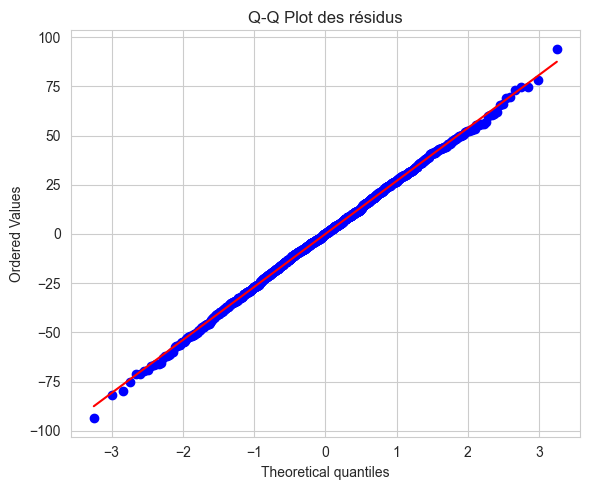


RÉSUMÉ : Toutes les conditions sont respectées -> ANOVA valide.


In [17]:
groups_promo = [df_promo[df_promo['promotion_type'] == g]['basket_amount'].values for g in order]

# --- Normalité des résidus ---
# Calcul des résidus (chaque observation - la moyenne de son groupe)
residuals = df_promo['basket_amount'] - df_promo.groupby('promotion_type')['basket_amount'].transform('mean')
stat_shap, p_shap = shapiro(residuals)
print(f"Test de normalité des résidus (Shapiro-Wilk) : p = {p_shap:.4f} -> {'Normal' if p_shap > 0.05 else 'Non normal'}")

# Normalité par groupe
print("\nNormalité par groupe :")
for name, group in zip(order, groups_promo):
    p = shapiro(group).pvalue
    print(f"  {name:20s} : p = {p:.4f} -> {'Normal' if p > 0.05 else 'Non normal'}")

# --- Homogénéité des variances ---
stat_lev, p_lev = levene(*groups_promo)
print(f"\nTest de Levene : p = {p_lev:.4f} -> {'Variances homogènes' if p_lev > 0.05 else 'Variances non homogènes'}")

# --- Q-Q Plot ---
fig, ax = plt.subplots(figsize=(6, 5))
stats.probplot(residuals, dist='norm', plot=ax)
ax.set_title('Q-Q Plot des résidus')
plt.tight_layout()
plt.show()

print("\nRÉSUMÉ : Toutes les conditions sont respectées -> ANOVA valide.")

### Q2.4 : ANOVA à un facteur

**Hypothèses** :
- H0 : mu_Control = mu_Discount = mu_FreeShipping = mu_Combo
- H1 : Au moins une moyenne diffère

On utilise `pingouin.anova()` qui retourne directement F, p-value et eta-carré :

In [18]:
# ANOVA avec pingouin (une seule fonction : F, p-value, eta-carré)
anova_result = pg.anova(data=df_promo, dv='basket_amount', between='promotion_type', detailed=True)
print(anova_result.to_string())

f_stat_anova = anova_result['F'].values[0]
p_value_anova = anova_result['p-unc'].values[0]
eta_sq = anova_result['np2'].values[0]

print(f"\nF-statistic : {f_stat_anova:.4f}")
print(f"P-value     : {p_value_anova:.6f}")
print(f"Eta-carré   : {eta_sq:.4f}")
print(f"\n-> p < 0.001 : ON REJETTE H0. Au moins une promotion diffère.")

           Source             SS    DF            MS          F         p-unc       np2
0  promotion_type   59691.730082     3  19897.243361  27.434902  3.685783e-17  0.064386
1          Within  867402.511971  1196    725.252936        NaN           NaN       NaN

F-statistic : 27.4349
P-value     : 0.000000
Eta-carré   : 0.0644

-> p < 0.001 : ON REJETTE H0. Au moins une promotion diffère.


**Vérification avec scipy** (pour comparaison) :

In [19]:
# Vérification avec scipy.stats.f_oneway
f_scipy, p_scipy = f_oneway(*groups_promo)
print(f"scipy f_oneway : F = {f_scipy:.4f}, p = {p_scipy:.6f}")
print("Les deux méthodes donnent le même résultat.")

scipy f_oneway : F = 27.4349, p = 0.000000
Les deux méthodes donnent le même résultat.


### Q2.5 : Tests post-hoc de Tukey

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2    meandiff p-adj   lower    upper   reject
------------------------------------------------------------------
      Combo       Control  -19.374    0.0 -25.0309 -13.7171   True
      Combo   Discount_10 -11.6213    0.0 -17.2782  -5.9644   True
      Combo Free_Shipping  -6.9059 0.0093 -12.5628   -1.249   True
    Control   Discount_10   7.7527 0.0025   2.0957  13.4096   True
    Control Free_Shipping  12.4681    0.0   6.8111   18.125   True
Discount_10 Free_Shipping   4.7154 0.1398  -0.9415  10.3723  False
------------------------------------------------------------------


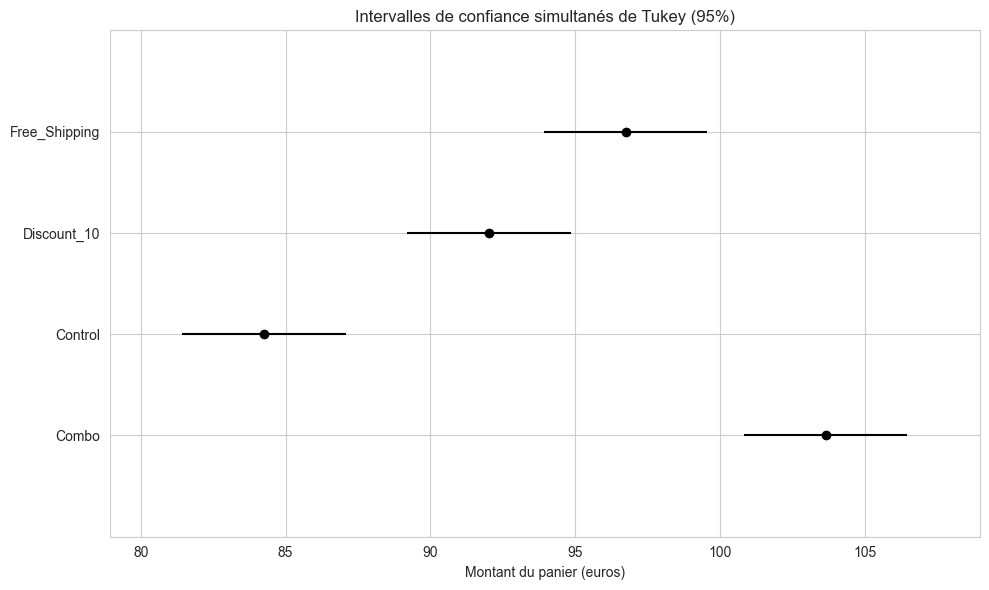

In [20]:
# Tukey HSD avec statsmodels
tukey = pairwise_tukeyhsd(df_promo['basket_amount'], df_promo['promotion_type'], alpha=0.05)
print(tukey)

# Visualisation
fig, ax = plt.subplots(figsize=(10, 5))
tukey.plot_simultaneous(ax=ax)
ax.set_title('Intervalles de confiance simultanés de Tukey (95%)')
ax.set_xlabel('Montant du panier (euros)')
plt.tight_layout()
plt.show()

**Alternative avec pingouin** (p-values ajustées plus lisibles) :

In [21]:
# Post-hoc avec pingouin (Tukey)
posthoc_pg = pg.pairwise_tukey(data=df_promo, dv='basket_amount', between='promotion_type')
print(posthoc_pg[['A', 'B', 'diff', 'p-tukey', 'hedges']].to_string())

print("\nHiérarchie : Control < (Discount_10 ≈ Free_Shipping) < Combo")
print("Seule paire non significative : Discount_10 vs Free_Shipping")

             A              B       diff       p-tukey    hedges
0        Combo        Control  19.373987  0.000000e+00  0.704696
1        Combo    Discount_10  11.621337  8.916102e-07  0.417466
2        Combo  Free_Shipping   6.905934  9.346089e-03  0.248458
3      Control    Discount_10  -7.752651  2.470651e-03 -0.296955
4      Control  Free_Shipping -12.468053  1.070017e-07 -0.478406
5  Discount_10  Free_Shipping  -4.715402  1.397717e-01 -0.178442

Hiérarchie : Control < (Discount_10 ≈ Free_Shipping) < Combo
Seule paire non significative : Discount_10 vs Free_Shipping


### Q2.6 : Taille d'effet - Eta-carré

In [22]:
# Déjà calculé par pingouin (colonne np2)
print(f"Eta-carré (η²) = {eta_sq:.4f}")
print(f"Le type de promotion explique {eta_sq*100:.2f}% de la variance du montant du panier.")

if eta_sq < 0.01:
    effect = 'négligeable'
elif eta_sq < 0.06:
    effect = 'petite'
elif eta_sq < 0.14:
    effect = 'moyenne'
else:
    effect = 'grande'

print(f"Taille d'effet : {effect}")
print(f"Les {(1-eta_sq)*100:.1f}% restants sont dus à d'autres facteurs.")

Eta-carré (η²) = 0.0644
Le type de promotion explique 6.44% de la variance du montant du panier.
Taille d'effet : moyenne
Les 93.6% restants sont dus à d'autres facteurs.


### Q2.7 : Scénario alternatif - Kruskal-Wallis

In [23]:
# Kruskal-Wallis avec pingouin
kw_result = pg.kruskal(data=df_promo, dv='basket_amount', between='promotion_type')
print("Kruskal-Wallis (pingouin) :")
print(kw_result.to_string())

# Comparaison
print(f"\nComparaison :")
print(f"  ANOVA          : F = {f_stat_anova:.4f}, p = {p_value_anova:.6f}")
print(f"  Kruskal-Wallis : H = {kw_result['H'].values[0]:.4f}, p = {kw_result['p-unc'].values[0]:.6f}")
print(f"\nMême conclusion. ANOVA préférable ici car conditions respectées.")

Kruskal-Wallis (pingouin) :
                 Source  ddof1          H         p-unc
Kruskal  promotion_type      3  77.843324  8.903547e-17

Comparaison :
  ANOVA          : F = 27.4349, p = 0.000000
  Kruskal-Wallis : H = 77.8433, p = 0.000000

Même conclusion. ANOVA préférable ici car conditions respectées.


### Q2.8 : Recommandation Business

In [24]:
# Analyse ROI
mean_control = groups_promo[0].mean()
roi_data = []

for name, group in zip(order, groups_promo):
    m = group.mean()
    gain = m - mean_control
    if name == 'Control':      cost = 0
    elif name == 'Discount_10': cost = 0.10 * m
    elif name == 'Free_Shipping': cost = 6.00
    else:                       cost = 0.15 * m + 6.00
    net = gain - cost
    roi_data.append({'Promotion': name, 'Panier': m, 'Gain': gain, 'Coût': cost, 'Net': net})

df_roi = pd.DataFrame(roi_data).round(2)
print(df_roi.to_string(index=False))

print(f"""
RECOMMANDATION :
  -> Déployer la LIVRAISON GRATUITE (meilleur ROI)
  -> Gain : +{roi_data[2]['Gain']:.2f} euros, Coût : {roi_data[2]['Coût']:.2f} euros, Net : {roi_data[2]['Net']:+.2f} euros/panier
  -> Éviter Discount -10% (ROI négatif : {roi_data[1]['Net']:+.2f} euros)
  -> Combo réservé aux opérations ponctuelles (ROI négatif : {roi_data[3]['Net']:+.2f} euros)
""")

    Promotion  Panier  Gain  Coût   Net
      Control   84.27  0.00  0.00  0.00
  Discount_10   92.02  7.75  9.20 -1.45
Free_Shipping   96.74 12.47  6.00  6.47
        Combo  103.64 19.37 21.55 -2.17

RECOMMANDATION :
  -> Déployer la LIVRAISON GRATUITE (meilleur ROI)
  -> Gain : +12.47 euros, Coût : 6.00 euros, Net : +6.47 euros/panier
  -> Éviter Discount -10% (ROI négatif : -1.45 euros)
  -> Combo réservé aux opérations ponctuelles (ROI négatif : -2.17 euros)



---
# PARTIE 3 : Kruskal-Wallis - Performance des Algorithmes

**Contexte** : Comparaison de 3 algorithmes de recommandation (Collaborative, Content, DeepLearning) sur le temps de chargement. Données non normales avec outliers.

In [25]:
df_algo = pd.read_csv('algorithm_performance_data.csv')
print(f"Données : {df_algo.shape[0]} lignes")
algo_order = ['Collaborative', 'Content', 'DeepLearning']
df_algo.head()

Données : 630 lignes


,request_id,algorithm,loading_time_ms
0,0,Collaborative,94.435863
1,1,Collaborative,110.267081
2,2,Collaborative,408.879060
3,3,Collaborative,477.979240
4,4,Collaborative,125.890182


### Q3.1 : Visualisation des distributions

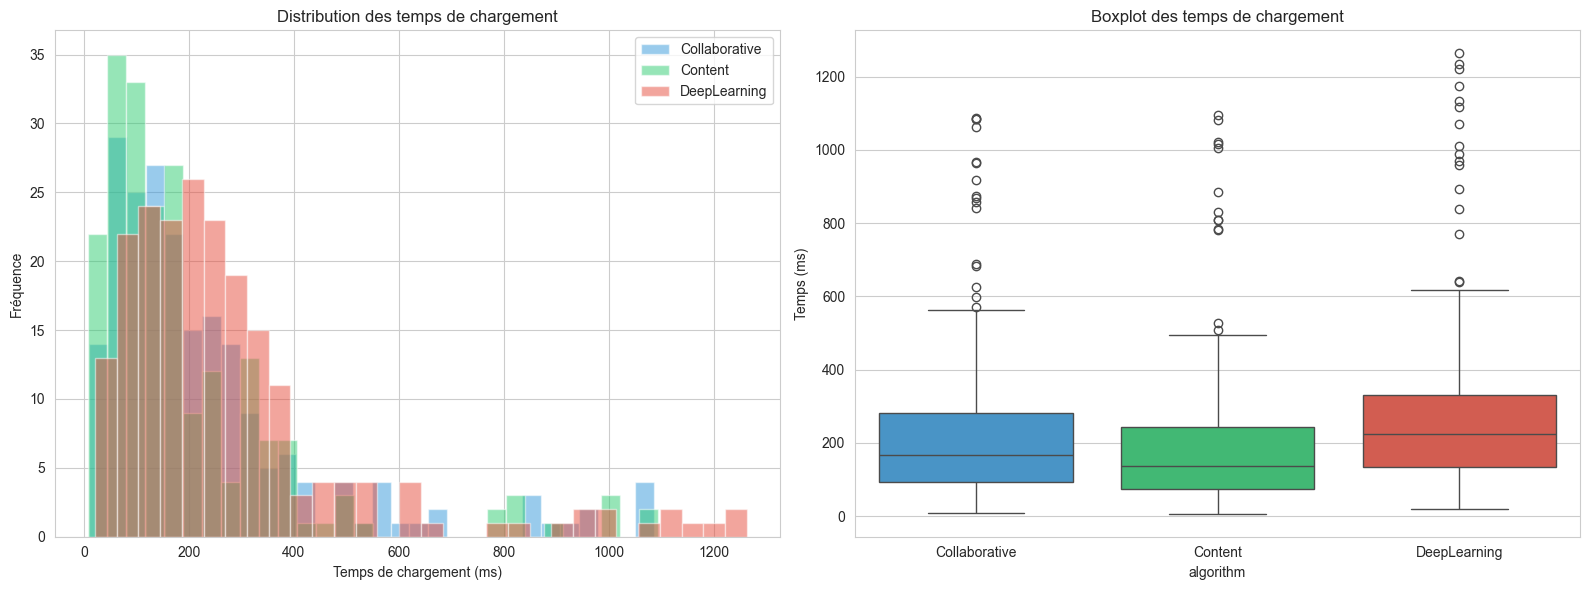

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogrammes
for algo, color in zip(algo_order, ['#3498db', '#2ecc71', '#e74c3c']):
    data = df_algo[df_algo['algorithm'] == algo]['loading_time_ms']
    axes[0].hist(data, bins=30, alpha=0.5, color=color, label=algo, edgecolor='white')
axes[0].set_xlabel('Temps de chargement (ms)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des temps de chargement')
axes[0].legend()

# Boxplot
sns.boxplot(data=df_algo, x='algorithm', y='loading_time_ms',
            order=algo_order, palette=['#3498db', '#2ecc71', '#e74c3c'], ax=axes[1])
axes[1].set_title('Boxplot des temps de chargement')
axes[1].set_ylabel('Temps (ms)')

plt.tight_layout()
plt.show()

### Q3.2 : Test de normalité

In [27]:
print("Test de Shapiro-Wilk par algorithme :")
for algo in algo_order:
    data = df_algo[df_algo['algorithm'] == algo]['loading_time_ms']
    p = shapiro(data).pvalue
    print(f"  {algo:15s} : p = {p:.6f} -> {'Normal' if p > 0.05 else 'NON normal'}")

print("\n-> Les 3 groupes sont très significativement non normaux (p ≈ 0).")
print("   Distribution gamma + outliers -> ANOVA inappropriée.")

Test de Shapiro-Wilk par algorithme :
  Collaborative   : p = 0.000000 -> NON normal
  Content         : p = 0.000000 -> NON normal
  DeepLearning    : p = 0.000000 -> NON normal

-> Les 3 groupes sont très significativement non normaux (p ≈ 0).
   Distribution gamma + outliers -> ANOVA inappropriée.


### Q3.3 : Justification du choix

On choisit **Kruskal-Wallis** car :
1. **Normalité violée** (Shapiro p ≈ 0 pour les 3 groupes)
2. **Outliers importants** (pics de latence 800-1400 ms) qui biaisent les moyennes
3. **Distributions asymétriques** (gamma) : la médiane est plus représentative que la moyenne

Le Kruskal-Wallis travaille sur les **rangs**, ce qui neutralise l'effet des outliers.

### Q3.4 : Test de Kruskal-Wallis

In [28]:
# Kruskal-Wallis avec pingouin (une seule fonction)
kw_algo = pg.kruskal(data=df_algo, dv='loading_time_ms', between='algorithm')
print("Kruskal-Wallis :")
print(kw_algo.to_string())

print(f"\nH = {kw_algo['H'].values[0]:.4f}, p = {kw_algo['p-unc'].values[0]:.6f}")
print("-> ON REJETTE H0 : Au moins un algorithme diffère significativement.")

Kruskal-Wallis :
            Source  ddof1          H         p-unc
Kruskal  algorithm      2  32.292517  9.722301e-08

H = 32.2925, p = 0.000000
-> ON REJETTE H0 : Au moins un algorithme diffère significativement.


### Q3.5 : Tests post-hoc de Dunn

In [ ]:
# Test de Dunn avec scikit-posthocs (correction de Bonferroni)
dunn_result = sp.posthoc_dunn(df_algo, val_col='loading_time_ms', group_col='algorithm', p_adjust='bonferroni')
print("P-values ajustées (Dunn + Bonferroni) :")
print(dunn_result.round(6))

print("\nInterprétation :")
for i in range(len(dunn_result)):
    for j in range(i+1, len(dunn_result)):
        g1 = dunn_result.index[i]
        g2 = dunn_result.columns[j]
        p = dunn_result.iloc[i, j]
        sig = 'Significatif' if p < 0.05 else 'Non significatif'
        print(f"  {g1} vs {g2} : p = {p:.6f} -> {sig}")

### Q3.6 : Médianes et intervalles interquartiles

In [ ]:
print(f"{'Algorithme':<15} {'Médiane':>10} {'Q1':>10} {'Q3':>10} {'IQR':>10}")
print('-' * 55)
for algo in algo_order:
    data = df_algo[df_algo['algorithm'] == algo]['loading_time_ms']
    med = data.median()
    q1, q3 = data.quantile(0.25), data.quantile(0.75)
    print(f"{algo:<15} {med:>9.2f}ms {q1:>9.2f}ms {q3:>9.2f}ms {q3-q1:>9.2f}ms")

print("\nContent est le plus rapide ET le plus stable (médiane et IQR les plus bas).")

### Q3.7 : Comparaison avec ANOVA

In [ ]:
groups_algo = [df_algo[df_algo['algorithm'] == a]['loading_time_ms'].values for a in algo_order]

f_stat_algo, p_anova_algo = f_oneway(*groups_algo)

print(f"ANOVA          : F = {f_stat_algo:.4f}, p = {p_anova_algo:.6f}")
print(f"Kruskal-Wallis : H = {kw_algo['H'].values[0]:.4f}, p = {kw_algo['p-unc'].values[0]:.6f}")
print(f"\nMême conclusion (significatif), mais Kruskal-Wallis est plus approprié ici.")
print(f"Le KW est même plus significatif (p plus petit) car les rangs neutralisent les outliers.")

### Q3.8 : Analyse des percentiles (P95)

In [ ]:
print("95e percentile (temps max pour 95% des requêtes) :")
for algo in algo_order:
    data = df_algo[df_algo['algorithm'] == algo]['loading_time_ms']
    p95 = data.quantile(0.95)
    print(f"  {algo:15s} : P95 = {p95:.2f} ms")

print("\nContent offre le meilleur P95 : même dans le pire cas, il reste le plus rapide.")

### Q3.9 : Recommandation Technique

In [ ]:
print(f"{'Critère':<20} {'Collaborative':>15} {'Content':>15} {'DeepLearning':>15}")
print('-' * 65)
for metric_name, func in [('Médiane', lambda d: f"{d.median():.0f} ms"),
                           ('IQR', lambda d: f"{d.quantile(0.75)-d.quantile(0.25):.0f} ms"),
                           ('P95', lambda d: f"{d.quantile(0.95):.0f} ms")]:
    vals = [func(df_algo[df_algo['algorithm'] == a]['loading_time_ms']) for a in algo_order]
    print(f"{metric_name:<20} {vals[0]:>15} {vals[1]:>15} {vals[2]:>15}")

print(f"""
RECOMMANDATION : Déployer l'algorithme CONTENT
  -> Médiane la plus basse (le plus rapide)
  -> IQR le plus étroit (le plus stable)
  -> P95 le meilleur (meilleur pire cas)
  -> Significativement meilleur que les autres (Dunn)
  -> DeepLearning à optimiser avant redéploiement
""")

---
# PARTIE 4 : Test de Wilcoxon - Score de Satisfaction

**Contexte** : On mesure la satisfaction (1-10) de 100 utilisateurs avant et après une mise à jour de l'interface. Mesures appariées.

In [ ]:
df_sat = pd.read_csv('satisfaction_scores_data.csv')
print(f"Données : {df_sat.shape[0]} utilisateurs")
df_sat.head()

### Q4.1 : Statistiques descriptives

In [ ]:
print(df_sat[['score_before', 'score_after', 'difference']].describe().round(2))

print(f"\nAmélioration moyenne : +{df_sat['difference'].mean():.2f} points")
print(f"Médiane de la différence : {df_sat['difference'].median():.0f}")

### Q4.2 : Visualisation de l'évolution

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogramme des différences
axes[0].hist(df_sat['difference'], bins=range(-2, 4), align='left', color='#3498db',
             edgecolor='black', rwidth=0.8)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Différence (après - avant)')
axes[0].set_ylabel('Nombre d\'utilisateurs')
axes[0].set_title('Distribution des différences')

# Scores avant/après
axes[1].boxplot([df_sat['score_before'], df_sat['score_after']],
                labels=['Avant', 'Après'], patch_artist=True,
                boxprops=dict(facecolor='#3498db', alpha=0.7))
axes[1].set_ylabel('Score de satisfaction')
axes[1].set_title('Scores avant vs après')

# Paired plot (lignes individuelles)
for _, row in df_sat.sample(30, random_state=42).iterrows():
    color = '#2ecc71' if row['difference'] > 0 else '#e74c3c' if row['difference'] < 0 else '#95a5a6'
    axes[2].plot([0, 1], [row['score_before'], row['score_after']], color=color, alpha=0.4)
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Avant', 'Après'])
axes[2].set_ylabel('Score de satisfaction')
axes[2].set_title('Évolution individuelle (30 utilisateurs)')

plt.tight_layout()
plt.show()

### Q4.3 : Test de normalité des différences

In [ ]:
stat_norm, p_norm = shapiro(df_sat['difference'])
print(f"Shapiro-Wilk sur les différences : p = {p_norm:.6f}")
print(f"-> Distribution {'normale' if p_norm > 0.05 else 'NON normale'}")
print(f"\nValeurs uniques : {sorted(df_sat['difference'].unique())}")
print(f"Les différences sont discrètes (entières) et asymétriques -> normalité impossible.")

### Q4.4 : Justification du choix

On choisit le **test de Wilcoxon signé** (et non le test t apparié) car :
1. **Normalité rejetée** (Shapiro p ≈ 0)
2. **Données ordinales** (scores 1-10, échelle de satisfaction)
3. **Distribution discrète** (seulement 4 valeurs de différence possibles)

### Q4.5 : Test de Wilcoxon signé

In [ ]:
# Test de Wilcoxon avec pingouin (une seule fonction : stat, p, taille d'effet, puissance)
wilcox_result = pg.wilcoxon(df_sat['score_after'], df_sat['score_before'], alternative='two-sided')
print("Test de Wilcoxon signé (pingouin) :")
print(wilcox_result.to_string())

p_wilcox = wilcox_result['p-val'].values[0]
print(f"\np-value = {p_wilcox:.6f}")
print(f"-> ON REJETTE H0 : L'amélioration est statistiquement significative.")

**Vérification avec scipy** :

In [ ]:
# Vérification avec scipy.stats.wilcoxon
stat_scipy, p_scipy = wilcoxon(df_sat['score_after'], df_sat['score_before'])
print(f"scipy wilcoxon : W = {stat_scipy:.4f}, p = {p_scipy:.6f}")

### Q4.6 : Pourcentage d'évolution

In [ ]:
n_users = len(df_sat)
increased = (df_sat['difference'] > 0).sum()
decreased = (df_sat['difference'] < 0).sum()
stable = (df_sat['difference'] == 0).sum()

print(f"Augmentation : {increased} utilisateurs ({increased/n_users*100:.1f}%)")
print(f"Diminution   : {decreased} utilisateurs ({decreased/n_users*100:.1f}%)")
print(f"Stable       : {stable} utilisateurs ({stable/n_users*100:.1f}%)")
print(f"\nRatio positif/négatif : {increased/decreased:.1f}")
print(f"Pour chaque utilisateur dégradé, {increased/decreased:.1f} se sont améliorés.")

### Q4.7 : Taille d'effet

In [ ]:
# pingouin fournit déjà le RBC (rank-biserial correlation)
# On peut aussi calculer r = Z / sqrt(N) manuellement

# Méthode avec RBC de pingouin
rbc = wilcox_result['RBC'].values[0]
print(f"Rank-Biserial Correlation (RBC) : {rbc:.4f}")

# Méthode r = Z / sqrt(N)
W = stat_scipy
n_non_zero = (df_sat['difference'] != 0).sum()
mu_W = n_non_zero * (n_non_zero + 1) / 4
sigma_W = np.sqrt(n_non_zero * (n_non_zero + 1) * (2 * n_non_zero + 1) / 24)
z_score = (W - mu_W) / sigma_W
r = abs(z_score) / np.sqrt(n_users)

print(f"r = |Z| / sqrt(N) = {r:.4f}")

if r < 0.1:    effect_w = 'négligeable'
elif r < 0.3:  effect_w = 'petite'
elif r < 0.5:  effect_w = 'moyenne'
else:          effect_w = 'grande'

print(f"Taille d'effet : {effect_w}")

### Q4.8 : Recommandation

In [ ]:
print(f"""
SYNTHÈSE PARTIE 4 - WILCOXON
{'='*50}
Score moyen avant : {df_sat['score_before'].mean():.2f} / 10
Score moyen après : {df_sat['score_after'].mean():.2f} / 10
Amélioration      : +{df_sat['difference'].mean():.2f} points

Test de Wilcoxon  : p = {p_wilcox:.6f} -> Significatif
Taille d'effet    : r = {r:.4f} -> {effect_w}
Utilisateurs améliorés : {increased}% vs {decreased}% dégradés

RECOMMANDATION : OUI, déployer la mise à jour.
- Significativité forte (p < 0.001)
- Taille d'effet {effect_w} (r = {r:.2f})
- Ratio bénéfice/risque favorable ({increased}/{decreased})
- Surveiller les {decreased}% d'utilisateurs dégradés
""")

---
# PARTIE 5 : Synthèse et Reporting

### Q5.1 : Dashboard récapitulatif

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Dashboard Récapitulatif - 4 Expérimentations', fontsize=16, fontweight='bold')

# 1. Test A/B
ax = axes[0, 0]
bars = ax.bar(['A (Contrôle)', 'B (Nouveau)'], [rate_A, rate_B],
              color=['#3498db', '#e74c3c'], width=0.5)
ax.errorbar(['A (Contrôle)', 'B (Nouveau)'], [rate_A, rate_B],
            yerr=[[rate_A-ci_A[0], rate_B-ci_B[0]], [ci_A[1]-rate_A, ci_B[1]-rate_B]],
            fmt='none', ecolor='black', capsize=8)
ax.set_title(f'Partie 1 : Test A/B (p={p_value_z:.4f})', fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
ax.set_ylabel('Taux de conversion')

# 2. ANOVA Promotions
ax = axes[0, 1]
sns.boxplot(data=df_promo, x='promotion_type', y='basket_amount',
            order=order, palette=['#95a5a6', '#3498db', '#2ecc71', '#e74c3c'], ax=ax)
ax.set_title(f'Partie 2 : ANOVA (F={f_stat_anova:.1f}, p<0.001)', fontsize=12)
ax.set_ylabel('Panier (euros)')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=15)

# 3. Kruskal-Wallis Algorithmes
ax = axes[1, 0]
sns.boxplot(data=df_algo, x='algorithm', y='loading_time_ms',
            order=algo_order, palette=['#3498db', '#2ecc71', '#e74c3c'], ax=ax)
ax.set_title(f'Partie 3 : Kruskal-Wallis (H={kw_algo["H"].values[0]:.1f}, p<0.001)', fontsize=12)
ax.set_ylabel('Temps (ms)')
ax.set_xlabel('')

# 4. Wilcoxon Satisfaction
ax = axes[1, 1]
ax.hist(df_sat['difference'], bins=range(-2, 4), align='left',
        color='#3498db', edgecolor='black', rwidth=0.8)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.set_title(f'Partie 4 : Wilcoxon (p<0.001, r={r:.2f})', fontsize=12)
ax.set_xlabel('Différence de score')
ax.set_ylabel('Fréquence')

plt.tight_layout()
plt.savefig('dashboard_recapitulatif.png', dpi=150, bbox_inches='tight')
plt.show()
print("Dashboard sauvegardé : dashboard_recapitulatif.png")

### Q5.2 : Tableau de synthèse

In [ ]:
synthese = pd.DataFrame({
    'Expérimentation': ['Page produit A/B', 'Promotions', 'Algorithmes', 'Satisfaction UX'],
    'Test utilisé': ['Test Z proportion', 'ANOVA (F)', 'Kruskal-Wallis', 'Wilcoxon signé'],
    'P-value': [f'{p_value_z:.4f}', f'{p_value_anova:.6f}', f'{kw_algo["p-unc"].values[0]:.6f}', f'{p_wilcox:.6f}'],
    'Significatif': ['Non', 'Oui', 'Oui', 'Oui'],
    'Taille effet': [f'h={h:.3f}', f'η²={eta_sq:.3f}', '-', f'r={r:.3f}'],
    'Recommandation': [
        'Prolonger le test',
        'Livraison gratuite',
        'Algo Content',
        'Déployer la MAJ'
    ]
})

print(synthese.to_string(index=False))

### Q5.3 : Impact business global

In [ ]:
print("""
IMPACT BUSINESS GLOBAL (estimations)
====================================

1. LIVRAISON GRATUITE (action immédiate) :
   +6.47 euros net / panier x 1000 commandes/jour = ~2.4M euros/an

2. ALGORITHME CONTENT (action immédiate) :
   Réduction médiane de ~86 ms vs DeepLearning
   -> Meilleure UX, potentiellement +conversion

3. MISE À JOUR UX (action immédiate) :
   +0.56 points de satisfaction -> fidélisation accrue

4. PAGE PRODUIT B (action différée) :
   Prolonger le test ~19 jours pour conclure
   Potentiel : +14.63% de conversions si confirmé

PRIORISATION :
  1. Quick wins : Livraison gratuite + Algo Content + MAJ UX
  2. Moyen terme : Prolonger test A/B page produit
  3. Long terme : Optimiser DeepLearning, tester d'autres promotions
""")

### Q5.4 : Limites et biais potentiels

In [ ]:
print("""
LIMITES ET BIAIS
=================

Test A/B :
  - Puissance insuffisante (44.9%) : risque de faux négatif
  - Durée de 14 jours : effets saisonniers non captés
  - Pas de segmentation (nouveaux vs récurrents)

ANOVA Promotions :
  - Coût de livraison estimé (6 euros) : à vérifier
  - Pas d'analyse du taux de conversion par promotion
  - η² = 0.064 : effet modéré, autres facteurs à explorer

Kruskal-Wallis Algorithmes :
  - Performance mesurée hors pic de charge
  - Qualité des recommandations non évaluée
  - Conditions réseau non contrôlées

Wilcoxon Satisfaction :
  - n = 100 : échantillon modeste
  - Effet de nouveauté possible (mesure à court terme)
  - Biais de sélection si panel non représentatif

ANALYSES COMPLÉMENTAIRES RECOMMANDÉES :
  - Segmentation des résultats (device, région, profil)
  - Suivi longitudinal (3 et 6 mois)
  - Tests bayésiens pour le test A/B
  - Analyse croisée promotions x taux de conversion
""")